Let's try to make a spring-damper system in Rust and plot it

In [7]:
:dep ndarray = { version = "0.16.1" }
:dep plotly = { version = "0.10.0" }
:dep nalgebra = { version = "0.33.1" }
extern crate ndarray;
extern crate plotly;
extern crate nalgebra;

use ndarray::{Array, Array2};
use nalgebra::{Matrix2, Vector2};
use plotly::common::Mode;
use plotly::layout::{Layout};
use plotly::{Plot, Scatter};

In [19]:
struct StateSpace {
    a: nalgebra::SMatrix<f64, 2, 2>,      // State matrix
    b: Matrix2<f64>,      // Input matrix
    x: Vector2<f64>,      // State vector: [position, velocity]
}

impl StateSpace {
    fn new(k: f64, c: f64, m: f64, initial_position: f64, initial_velocity: f64) -> Self {
        let a = Matrix2::new(0.0, 1.0, -k / m, -c / m);
        let b = Matrix2::new(0.0, 0.0, 1.0 / m, 0.0);
        let x = Vector2::new(initial_position, initial_velocity);
        
        Self { a, b, x }
    }

    fn compute_derivative(&self, state: &Vector2<f64>, external_force: &Vector2<f64>) -> Vector2<f64> {
        self.a * state + self.b * external_force
    }

    fn step(&mut self, external_force: &Vector2<f64>, dt: f64) {
        // Runge-Kutta 4th order increments ( I think this is a wrong implementation)
        let k1 = self.compute_derivative(&self.x, external_force);
        let k2 = self.compute_derivative(&(self.x + 0.5 * k1 * dt), external_force);
        let k3 = self.compute_derivative(&(self.x + 0.5 * k2 * dt), external_force);
        let k4 = self.compute_derivative(&(self.x + k3 * dt), external_force);
        
        // RK4 update: x = x + (1/6)*(k1 + 2*k2 + 2*k3 + k4) * dt
        self.x += (k1 + 2.0 * k2 + 2.0 * k3 + k4) * (dt / 6.0);
    }

    fn position(&self) -> f64 {
        self.x[0]
    }

    fn velocity(&self) -> f64 {
        self.x[1]
    }
}


In [20]:
let mut system = StateSpace::new(10.0, 1.0, 1.0, 0.0, 0.0); // k, c, m, initial_x, initial_v
let dt = 0.01; // time step
let runtime = 10.0; // total runtime in seconds
let steps = (runtime / dt) as usize; // total number of steps

let external_force = Vector2::new(10.0, 0.0); // constant force for this example

// Define the time vector
let time: Vec<f64> = (0..steps).map(|i| i as f64 * dt).collect();

// Create an ndarray to store position and velocity for each time step
let mut results = Array2::<f64>::zeros((steps, 2)); // Columns: position, velocity

for i in 0..steps {
    // Store position and velocity in the ndarray
    results[[i, 0]] = system.position();
    results[[i, 1]] = system.velocity();
    
    // Step the simulation
    system.step(&external_force, dt);
}

()

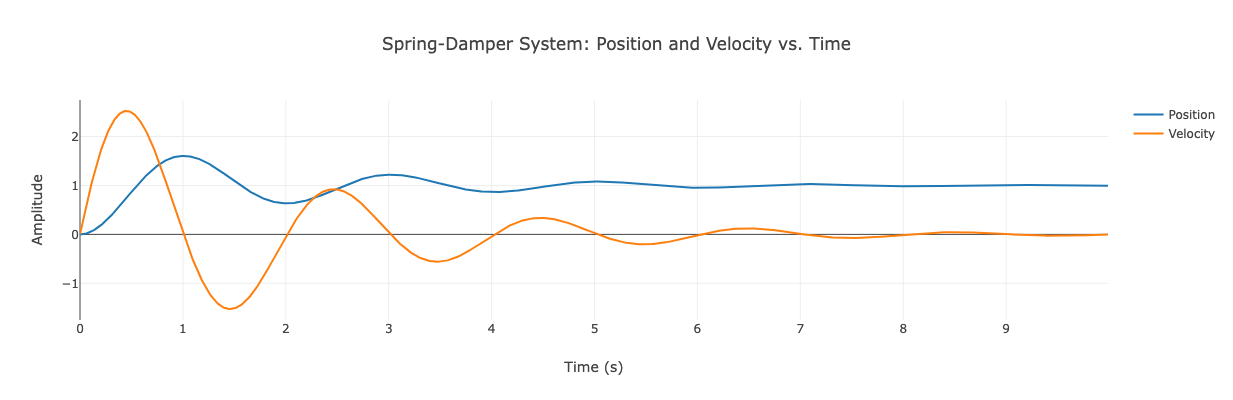

In [21]:
// Extract position and velocity for plotting
let position: Vec<f64> = results.column(0).to_vec();
let velocity: Vec<f64> = results.column(1).to_vec();

use plotly::*;
// Plot position vs. time
let trace_position = Scatter::new(time.clone(), position)
    .mode(plotly::common::Mode::Lines)
    .name("Position");
let mut plot = Plot::new();
plot.add_trace(trace_position);

// Plot velocity vs. time
let trace_velocity = Scatter::new(time.clone(), velocity)
    .mode(plotly::common::Mode::Lines)
    .name("Velocity");
plot.add_trace(trace_velocity);

// Set layout properties
let layout = Layout::new()
    .title("Spring-Damper System: Position and Velocity vs. Time")
    .x_axis(plotly::layout::Axis::new().title("Time (s)"))
    .y_axis(plotly::layout::Axis::new().title("Amplitude"))
    .height(400)
    .width(800);

plot.set_layout(layout);
plot.lab_display();